# Data Analytics II - Final Project Part I

## Methodology:

- Feature scaling

- Feature importance using Gini Index

- Deletion of unnecessary features

- Correlation between features

- Visualization of some of the best features

For each classifier:

    - SFS analysis using standard hyperparameters
    
    - Gridsearch using the selected features

    - Analysis of classification metrics

- Fitting of the best model with all the training data

- Predictions to the test dataset

## Imports

In [64]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sb
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams.update({
  'figure.figsize':  [16, 16],
  'axes.labelsize':  16,
  'axes.titlesize':  18,
  'font.size':       16,
  'legend.fontsize': 10,
  'xtick.labelsize': 12,
  'ytick.labelsize': 12
})

## Training dataset preprocessing

In [2]:
scaler  = StandardScaler()

df = pd.read_csv(r"C:\Users\simle\OneDrive\Bureau\Programmation\WWU - DA2 Project\train_set.csv")
y  = df['y']
X  = pd.DataFrame(
    data    = scaler.fit_transform(df.drop('y', axis=1)),
    columns = df.columns.drop('y')
)

In [3]:
df_label_counts = pd.DataFrame(
    data    = np.transpose(np.unique(y, return_counts=True)),
    columns = ['label', 'count'] 
).sort_values(
    by        = 'count',
    ascending = False
).reset_index(
    drop = True
)

df_label_counts['pct'] = 100*df_label_counts['count']/y.size

df_label_counts

,label,count,pct
0,teddy,7409,23.361922
1,golden_retriever,5315,16.75916
2,Labrador_retriever,3540,11.162263
3,toy_poodle,2885,9.096929
4,Cardigan,2869,9.046478
5,Border_collie,2554,8.053226
6,miniature_schnauzer,2302,7.258624
7,Siberian_husky,1120,3.531563
8,French_bulldog,1081,3.408589
9,pug,758,2.390112


In [37]:
encoder = LabelEncoder()

y = encoder.fit_transform(df['y'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Feature Importance

In [33]:
rf = RandomForestClassifier() 
rf.fit(X_train, y_train)

RandomForestClassifier()

In [34]:
max_features = int(df.columns.size/3)

df_feature_importances = pd.DataFrame(
    data    = zip(df.columns.drop('y'), rf.feature_importances_),
    columns = ['feature', 'importance'] 
).sort_values(
    by        = 'importance',
    ascending = False,
).reset_index(
    drop = True
)[:max_features]

fig = px.line(
    data_frame = df_feature_importances,
    x          = 'feature',
    y          = 'importance'
)
fig.show()

## Deletion of unnecessary features

In [35]:
X_train = df[df_feature_importances['feature']]
X_train.shape

(31714, 33)

In [38]:
len(X_train)

28542

## Correlation between features

<AxesSubplot:>

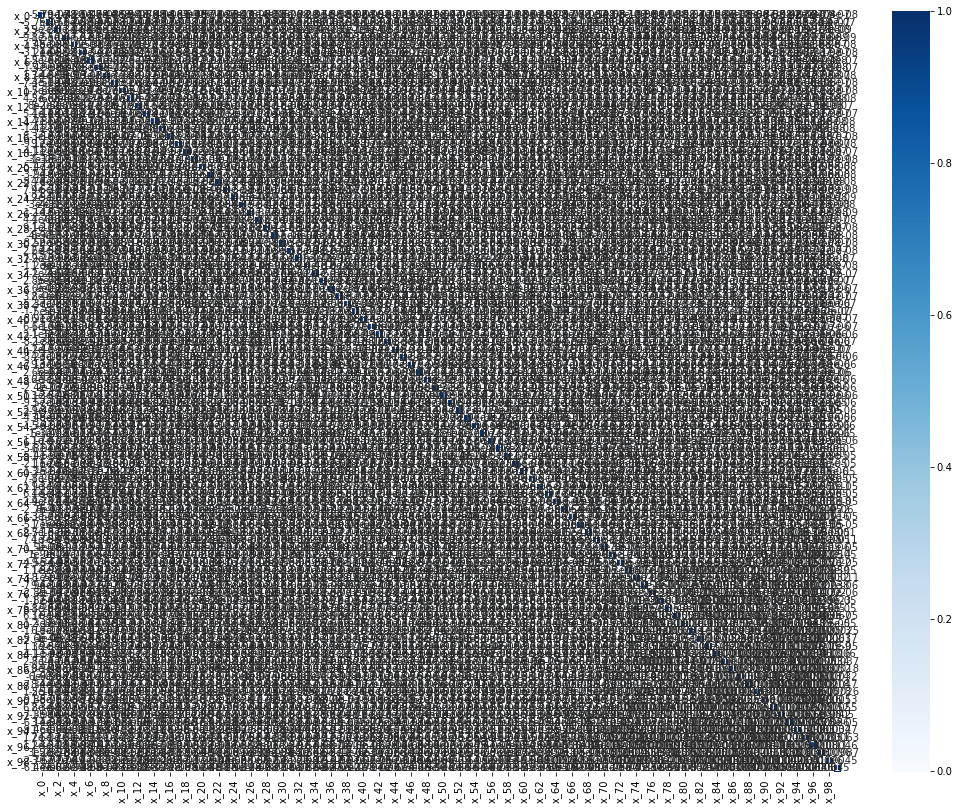

In [15]:
fig, ax = plt.subplots(figsize=(18,14))
sb.heatmap(X.corr(), cmap="Blues", annot=True, linewidths=0.1)

Features are not correlated: no need to remove correlated features to prevent overfitting!

## SFS and Gridsearch to each classifier

OBS: no need for SFS when using Random Forests. No need for hyperparameter tunning for Discriminant Analysis.

In [16]:
n_jobs               = -1
cv                   = 5
verbose              = 3
n_features_to_select = int(df.columns.size/10)
scoring              = 'accuracy'

### Random Forest

No need for SFS when using trees!

In [39]:
gs_rf = GridSearchCV(
    estimator  = RandomForestClassifier(),
    n_jobs     = n_jobs,
    cv         = cv,
    verbose    = verbose,
    scoring    = scoring,
    param_grid = dict(
        n_estimators      = [100],
        criterion         = ['gini'],
        max_depth         = [18], #[18, 20, 22],
        min_samples_split = [0.0001], #[0.0001, 0.0005, 0.0010],
        class_weight      = [None],
        max_samples       = [0.66]
    )
)
gs_rf.fit(X_train, y_train)
gs = gs_rf
print('Estimator:', gs.estimator.__class__.__name__)
print('Best result: {:.3f} +- {:.3f}'.format(
    gs.cv_results_['mean_test_score'][gs.best_index_],
    gs.cv_results_['std_test_score'][gs.best_index_],
))
print('Best hyperparameters:', gs.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Estimator: RandomForestClassifier
Best result: 0.881 +- 0.001
Best hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_samples': 0.66, 'min_samples_split': 0.0001, 'n_estimators': 100}


In [18]:
gs.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 18,
 'max_samples': 0.66,
 'min_samples_split': 0.0001,
 'n_estimators': 100}

In [42]:
rfc = RandomForestClassifier(class_weight = None,
                            criterion = "gini",
                            max_depth = 18,
                            max_samples = 0.66,
                            min_samples_split = 0.0001,
                            n_estimators = 100)

rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=18, max_samples=0.66, min_samples_split=0.0001)

In [43]:
pred = rfc.predict(X_test)

In [45]:
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, pred)))

Model accuracy score with 100 decision-trees : 0.8704


### LDA

No need for gridsearch when using discriminant analysis!

In [ ]:
sfs_lda = SequentialFeatureSelector(
    estimator            = LinearDiscriminantAnalysis(),
    direction            = 'forward',
    n_features_to_select = n_features_to_select,
    n_jobs               = n_jobs,
    cv                   = cv,
    scoring              = scoring,
)
sfs_lda.fit(X, y)

In [ ]:
kf       = KFold(n_splits=cv, shuffle=True)
features = []
accs     = []
stds     = []

for current_feature in sfs_lda.get_feature_names_out():
    features.append(current_feature)
    inner_accs = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index][features], X.loc[test_index][features]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        clf = sfs_lda.estimator
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        inner_accs.append(accuracy_score(y_test, y_pred))
        
    accs.append(np.mean(inner_accs))
    stds.append(np.std(inner_accs))

In [ ]:
fig = px.line(
    x       = sfs_lda.get_feature_names_out(),
    y       = accs,
    error_y = stds,
    title   = 'Sequential Feature Selector: ' + sfs_lda.estimator.__class__.__name__,
    labels  = dict(
        x = 'Added feature', 
        y = 'Accuracy'
    )
)
fig.show()

In [ ]:
features_lda = sfs_lda.get_feature_names_out()[:8]
gs_lda = GridSearchCV(
    estimator  = LinearDiscriminantAnalysis(),
    n_jobs     = n_jobs,
    cv         = cv,
    verbose    = verbose,
    scoring    = scoring,
    param_grid = dict()
)
gs_lda.fit(X[features_lda], y)
gs = gs_lda
print('Estimator:', gs.estimator.__class__.__name__)
print('Best result: {:.3f} +- {:.3f}'.format(
    gs.cv_results_['mean_test_score'][gs.best_index_],
    gs.cv_results_['std_test_score'][gs.best_index_],
))
print('Best features:', features_lda)
print('Best hyperparameters:', gs.best_params_)

### Suppor Vector Machine

    SFS with standard parameters and then gridsearch with selected features
    
### K Nearest Neighbors

    SFS with standard parameters and then gridsearch with selected features
    
### So on...

In the end, test XGBoost -> this is probably the one that will work the best, but its not from sklearn. So we can do this later.

## XGBoost

In [47]:
import xgboost as xgb

## Hyper parameters

In [50]:
params = { 'max_depth': [3, 4, 5],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'gamma' : [0, 0.25, 1.0],
           'reg_lambda' : [0, 1.0, 10.0],
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'scale_pos_weight' : [1, 3, 5]}

xgbr = xgb.XGBClassifier(seed = 42)

clf_xgb = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)

clf_xgb.fit(X_train, y_train)                                  
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[14:05:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:06:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:07:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/lea

[14:28:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:31:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be 

[14:53:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:54:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be 

[15:16:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:17:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:18:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be 

[15:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:36:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:37:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be 

[15:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:54:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be 

[16:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:14:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:15:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be 

NameError: name 'clf' is not defined

In [52]:
clf_xgb.best_params_

{'subsample': 0.7,
 'scale_pos_weight': 5,
 'reg_lambda': 1.0,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0,
 'colsample_bytree': 0.4,
 'colsample_bylevel': 0.7}

In [54]:
clf_new = xgb.XGBClassifier(subsample= 0.7,             #WHAT I GOT AFTER RUNNING THE CELL ABOVE
                     scale_pos_weight = 5,
                     reg_lambda = 1.0,
                     max_depth = 4,
                     learning_rate= 0.2,
                     gamma = 0,
                     colsample_bytree= 0.4,
                     colsample_bylevel= 0.7)

In [53]:
params_loaded = {'subsample': 0.7,
 'scale_pos_weight': 5,
 'reg_lambda': 1.0,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0,
 'colsample_bytree': 0.4,
 'colsample_bylevel': 0.7}

In [55]:
clf_new.fit(X_train, y_train)

[16:30:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [58]:
pred_xgb = clf_new.predict(X_test)

In [59]:
print('Model accuracy score with XGB : {0:0.4f}'. format(accuracy_score(y_test, pred_xgb)))

Model accuracy score with XGB : 0.8742


In [11]:
clf_xgb = xgb.XGBClassifier(subsample= 0.7,             #WHAT I GOT AFTER RUNNING THE CELL ABOVE
                     n_estimators= 100,
                     max_depth= 3,
                     learning_rate= 0.1,
                     colsample_bytree= 0.5,
                     colsample_bylevel= 0.8999999999999999)

In [60]:
cm = confusion_matrix(y_test, pred_xgb)

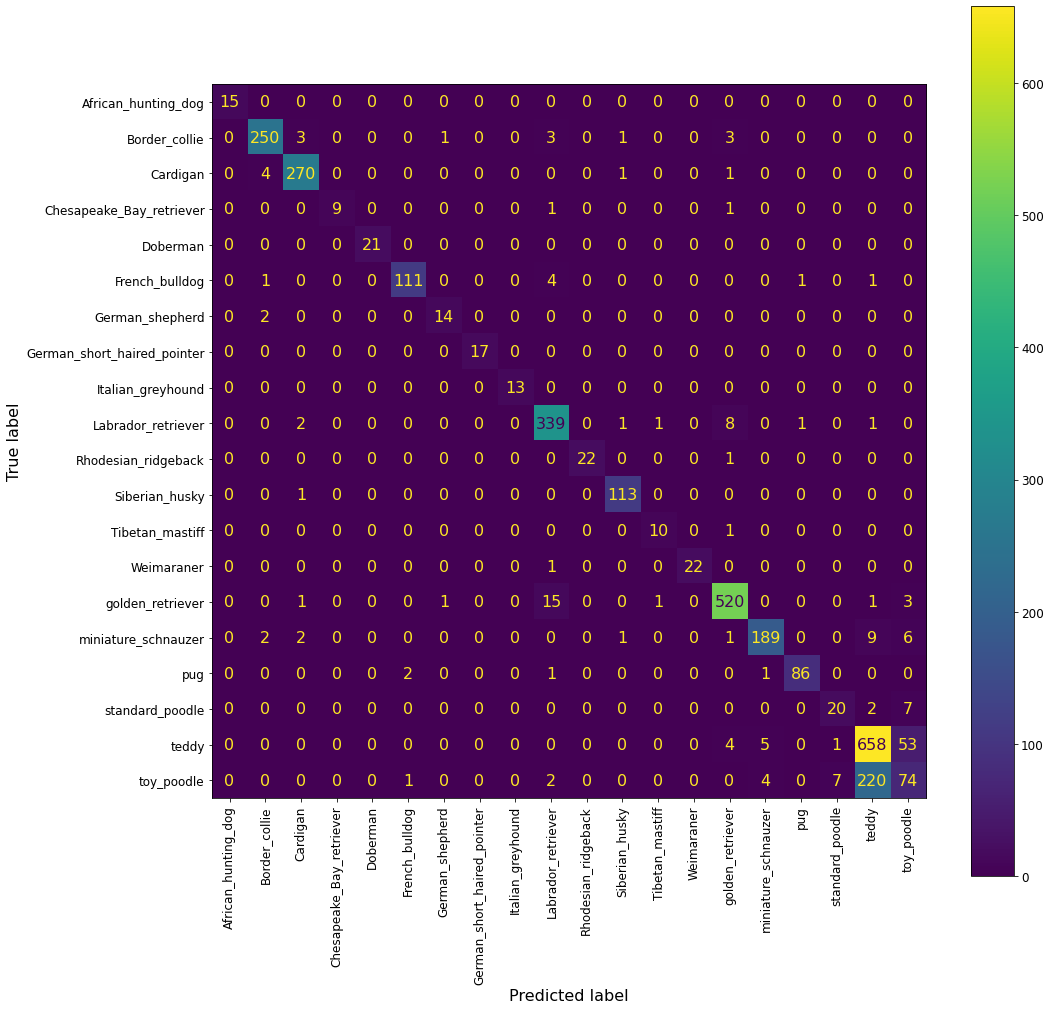

In [65]:
disp = ConfusionMatrixDisplay(
  confusion_matrix = cm,
  display_labels   = encoder.classes_
)
disp.plot()
plt.xticks(rotation=90)
plt.show()